In [35]:
import sys

from datasets.llff_image_pose import LLFFImagePose

print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
from ATE.trajectory_utils import compute_angle
import os
from tqdm.notebook import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
DEVICE = 'cpu'
OUTPUT_ROOT_DIR = 'output/'

3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]


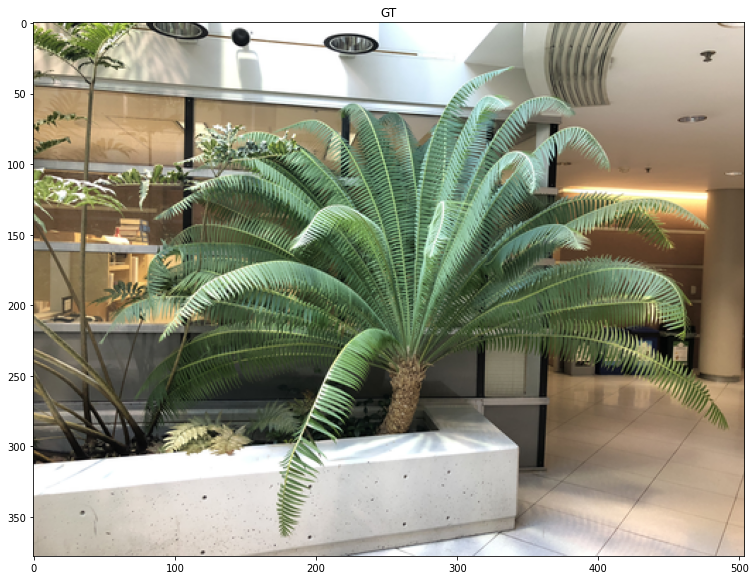

In [36]:
output_dir = os.path.join(OUTPUT_ROOT_DIR, 'llff', 'fern')
dataset_root_dir = '/home/dkomorowicz/raid/nerf--/LLFF/fern'
dataset = LLFFImagePose(root_dir=dataset_root_dir)

# dataset_root_dir = '/home/dkomorowicz/raid/phototourism/nepszinhaz'
# output_dir = os.path.join(OUTPUT_ROOT_DIR, 'phototourism', 'nepszinhaz')
# dataset = PhototourismImagePose(dataset_root_dir, img_downscale=8, use_cache=True)

os.makedirs(output_dir, exist_ok=True)

sample = dataset[0]
img_gt = sample['img'].permute(1, 2, 0).numpy()
c2w = sample['c2w'].numpy()

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.title('GT')
plt.imshow(img_gt)
plt.show()


In [6]:
# Pose already centered.
print(f'c2w:\n{c2w}')
translation = c2w[..., 3]
print(f'Translation: {translation}')
distance_from_center = np.linalg.norm(c2w[..., 3])
print(f'Distance from center: {distance_from_center}')

pose_homo = np.eye(4)
pose_homo[:3] = c2w  # convert to homogeneous coordinate for faster computation
# by simply adding 0, 0, 0, 1 as the last row
# print(f'Homo:\n{pose_homo}')
print(f'Angle {compute_angle(pose_homo)}')

c2w:
[[ 0.5731521   0.11251929  0.8116872   0.5056278 ]
 [ 0.12126215 -0.99126863  0.05178742  0.05833965]
 [ 0.8104271   0.06874486 -0.58179206  0.20862825]]
Translation: [0.5056278  0.05833965 0.20862825]
Distance from center: 0.5500806570053101
Angle 179.45213063251484


# Absolute Pose Error
APE should return zero values when given same poses.

In [7]:
from utils.abs_pose_error import AbsolutePoseError as APE

print(f'full_transformation_error: {APE.full_transformation_error(pose_homo, pose_homo)}')
print(f'trans_error: {APE.translation_error(translation, translation)}')
print(f'rotation_error: {APE.rotation_error(pose_homo, pose_homo)}')
print(f'angle_error: {APE.angle_error(pose_homo, pose_homo)}')

full_transformation_error: 1.4894649328968775e-16
trans_error: 0.0
rotation_error: 1.26578363242917e-16
angle_error: 0.0


In [8]:
def get_pose_angle_translation(sample, show_image=True):
    """
    Get homogenous pose matrix, angle and translation vector.
    """
    # print(f'Pose {pose_idx}')
    c2w = sample['c2w'].numpy()

    if show_image:
        img_gt = sample['img'].permute(1, 2, 0).numpy()
        plt.subplots(figsize=(15, 8))
        plt.tight_layout()
        plt.title('GT')
        plt.imshow(img_gt)
        plt.show()

    # Pose already centered.
    # print(f'c2w:\n{c2w}')
    translation = c2w[..., 3]
    # print(f'Translation: {translation}')
    # distance_from_center = np.linalg.norm(c2w[..., 3])
    # print(f'Translation Distance from center: {distance_from_center}')

    pose_homo = np.eye(4)
    pose_homo[:3] = c2w  # convert to homogeneous coordinate for faster computation
    # by simply adding 0, 0, 0, 1 as the last row
    # print(f'Homo:\n{pose_homo}')
    angle = compute_angle(pose_homo)
    # print(f'Angle {angle}')
    return pose_homo, angle, translation

In [9]:
# Compute pose, angle and translations for APE check.
pose_angle_translations = [get_pose_angle_translation(dataset[i], show_image=False)
                           for i in range(0, len(dataset), 1)]


Check APE between adjacent poses.

In [9]:
for i in range(len(pose_angle_translations) - 1):
    for j in range(i + 1, min(i + 3, len(dataset))):
        print(f'Pose {i}->{j}')
        pose_0, angle_0, t_0 = pose_angle_translations[i]
        pose_1, angle_1, t_1 = pose_angle_translations[j]

        print(f'full_transformation_error: {APE.full_transformation_error(pose_0, pose_1)}')
        print(f'trans_error: {APE.translation_error(t_0, t_1)}')
        print(f'rotation_error: {APE.rotation_error(pose_0, pose_1)}')
        print(f'angle_error: {APE.angle_error(pose_0, pose_1)}')
        print(f'Angle difference: {abs(angle_1 - angle_0)}')
        print(f'distance: {np.linalg.norm(t_0 - t_1)}')
        print('\n\n')

Pose 0->1
full_transformation_error: 0.17680913942283477
trans_error: 0.15861579775810242
rotation_error: 0.07811849158383614
angle_error: 3.165301125765714
Angle difference: 2.5805602139399153
distance: 0.15861579775810242



Pose 0->2
full_transformation_error: 0.34025331948843646
trans_error: 0.3104887008666992
rotation_error: 0.13917286774598722
angle_error: 5.640772109297337
Angle difference: 4.298322300599764
distance: 0.3104887008666992



Pose 1->2
full_transformation_error: 0.16478289820569228
trans_error: 0.15213054418563843
rotation_error: 0.063322213981854
angle_error: 2.5657072829444445
Angle difference: 1.717762086659849
distance: 0.15213054418563843



Pose 1->3
full_transformation_error: 0.41396696888727896
trans_error: 0.3653973639011383
rotation_error: 0.19455952517392172
angle_error: 7.888665774946268
Angle difference: 2.445300023711327
distance: 0.3653973639011383



Pose 2->3
full_transformation_error: 0.25216311442308886
trans_error: 0.2133961170911789
rotation_er

In [10]:
full_transformation_errors = np.empty((len(pose_angle_translations), len(pose_angle_translations)))
for i in range(len(pose_angle_translations)):
    pose_0, angle_0, t_0 = pose_angle_translations[i]
    for j in range(len(pose_angle_translations)):
        pose_1, angle_1, t_1 = pose_angle_translations[j]
        error = APE.full_transformation_error(pose_0, pose_1)
        full_transformation_errors[i][j] = error

In [13]:
for _, angle, _ in pose_angle_translations:
    print(angle)

179.45213063251484
176.98435331060637
176.69790647366636
177.8223731923762
178.40731669525474
176.77480992239927
174.21354869708003
176.73616192637306
166.35408508601998
179.07011455156112
175.7288655561993
177.2625827296571
174.823067624517
178.12293777818428
179.5002250655971
176.50357585868971
179.8972079274581
179.08144173019906
179.1214572094834
178.2341934221437
177.75066341884406
169.3563923636434
171.9921199607006
153.91377733372923
172.85025265651237
176.92753560412606


In [24]:
def create_heatmap(matrix, title, fig_size=(18.5, 10.5)):
    fig, ax = plt.subplots()
    fig.set_size_inches(*fig_size)
    im = ax.imshow(matrix, cmap='plasma')
    fig.colorbar(im)
    num_poses = matrix.shape[0]
    tick_labels = [f'Pose {i}' for i in range(num_poses)]
    # We want to show all ticks...
    ax.set_xticks(np.arange(num_poses))
    ax.set_yticks(np.arange(num_poses))
    # ... and label them with the respective list entries
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [14]:
np.save(os.path.join(output_dir, 'full_transformation_errors.npy'), full_transformation_errors)

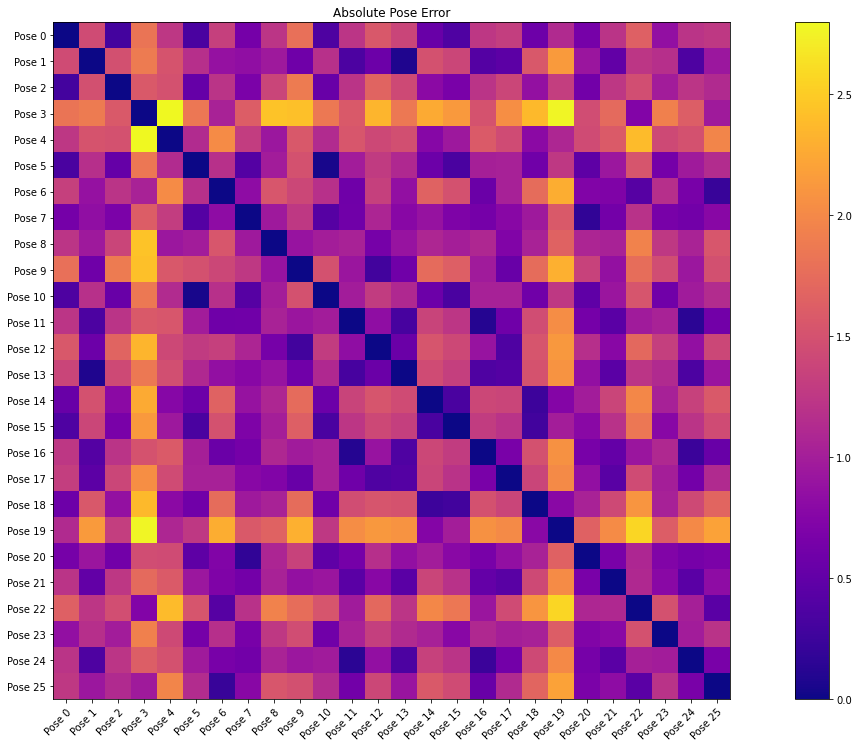

In [12]:
create_heatmap(full_transformation_errors, title="Absolute Pose Error")

# VGG Loss
Check VGG feature and style losses for different poses.

In [3]:
from feature_losses.vgg_loss import get_style_model_and_losses
import torch
from torchvision import models

NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()
for param in cnn.parameters():
    param.requires_grad_(False)

cnn_normalization_mean = torch.tensor(NORMALIZATION_MEAN).to(DEVICE)
cnn_normalization_std = torch.tensor(NORMALIZATION_STD).to(DEVICE)

Create model and losses.

In [4]:
reference_img = dataset[0]['img'].to(DEVICE).unsqueeze(0)  # Add batch dimension
input_img = dataset[1]['img'].to(DEVICE).unsqueeze(0)  # Add batch dimension
style_img = reference_img
content_img = reference_img

model, style_losses, content_losses = get_style_model_and_losses(
    cnn,
    cnn_normalization_mean,
    cnn_normalization_std,
    style_img,
    content_img,
    device=DEVICE,
)

In [ ]:
model(input_img)

for i, sl in enumerate(style_losses):
    print(f'Style Loss {i}: {sl.loss}')

for i, cl in enumerate(content_losses):
    print(f'Content Loss {i}: {cl.loss}')

/home/dkomorowicz/mert/projects/adl4cv/feature_losses/vgg_loss.py:42: UserWarning: Using a target size (torch.Size([1, 128, 1360, 1474])) that is different to the input size (torch.Size([1, 128, 764, 1194])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = F.mse_loss(x, self.target)


RuntimeError: The size of tensor a (1194) must match the size of tensor b (1474) at non-singleton dimension 3

Check VGG Loss between neighboring poses, using the first pose as reference image.

In [18]:
def get_vgg_scores(reference_img, input_img, device):
    reference_img = reference_img.to(device).unsqueeze(0)
    input_img = input_img.to(device).unsqueeze(0)
    style_img = reference_img
    content_img = reference_img

    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        cnn_normalization_mean,
        cnn_normalization_std,
        style_img,
        content_img,
        device=device,
    )
    with torch.no_grad():
        model(input_img)

    style_score = 0
    content_score = 0

    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss
    return style_score, content_score

In [57]:
for i in range(len(dataset) - 1):
    for j in range(i + 1, min(i + 3, len(dataset))):
        print(f'Pose {i}->{j}')
        style_score, content_score = get_vgg_scores(reference_img=dataset[i]['img'],
                                                    input_img=dataset[j]['img'],
                                                    device=DEVICE)
        print(f'Style score: {style_score}')
        print(f'Content score: {content_score}')

Pose 0->1
Style score: 5.9238042013021186e-05
Content score: 30.69197654724121
Pose 0->2
Style score: 8.866397547535598e-05
Content score: 35.917694091796875
Pose 1->2


KeyboardInterrupt: 

In [31]:
import torchvision.transforms as T
from PIL import Image

DEVICE = 'cuda:0'
style_score_matrix = np.empty((len(dataset), len(dataset)))
content_score_matrix = np.empty((len(dataset), len(dataset)))
for i in tqdm(range(len(dataset))):
    reference_img = dataset[i]['img']
    ref_image_size = reference_img.shape[1:]
    print(f'Ref image size {ref_image_size}')
    reference_img = reference_img.to(DEVICE).unsqueeze(0)
    style_img = reference_img
    content_img = reference_img
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn.to(DEVICE),
        cnn_normalization_mean.to(DEVICE),
        cnn_normalization_std.to(DEVICE),
        style_img,
        content_img,
        device=DEVICE,
    )

    resize_trafo = T.Resize(size=ref_image_size, interpolation=Image.BICUBIC)
    for j in tqdm(range(1, len(dataset)), leave=False):
        input_img = dataset[j]['img']
        input_img = input_img.to(DEVICE).unsqueeze(0)
        # print(f'input img size  {input_img.shape}')
        input_img = resize_trafo(input_img)
        # print(f'input img size after resize {input_img.shape}')
        # print(f'ref img size {reference_img.shape}')
        with torch.no_grad():
            model(input_img)

        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss
        style_score_matrix[i][j] = style_score.item()
        content_score_matrix[i][j] = content_score.item()
    del model

  0%|          | 0/26 [00:00<?, ?it/s]

Ref image size torch.Size([680, 737])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([382, 597])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([474, 738])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([507, 779])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([460, 551])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([449, 536])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([761, 1119])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([385, 620])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([449, 489])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([363, 565])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([452, 490])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([269, 334])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([752, 498])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([454, 708])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([619, 456])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([763, 749])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([181, 247])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([370, 686])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([716, 1085])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([450, 671])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([737, 1133])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([457, 697])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([594, 733])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([448, 497])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([454, 539])


  0%|          | 0/25 [00:00<?, ?it/s]

Ref image size torch.Size([247, 377])


  0%|          | 0/25 [00:00<?, ?it/s]

In [33]:
np.save(os.path.join(output_dir, 'content_score_matrix.npy'), content_score_matrix)
np.save(os.path.join(output_dir, 'style_score_matrix.npy'), style_score_matrix)

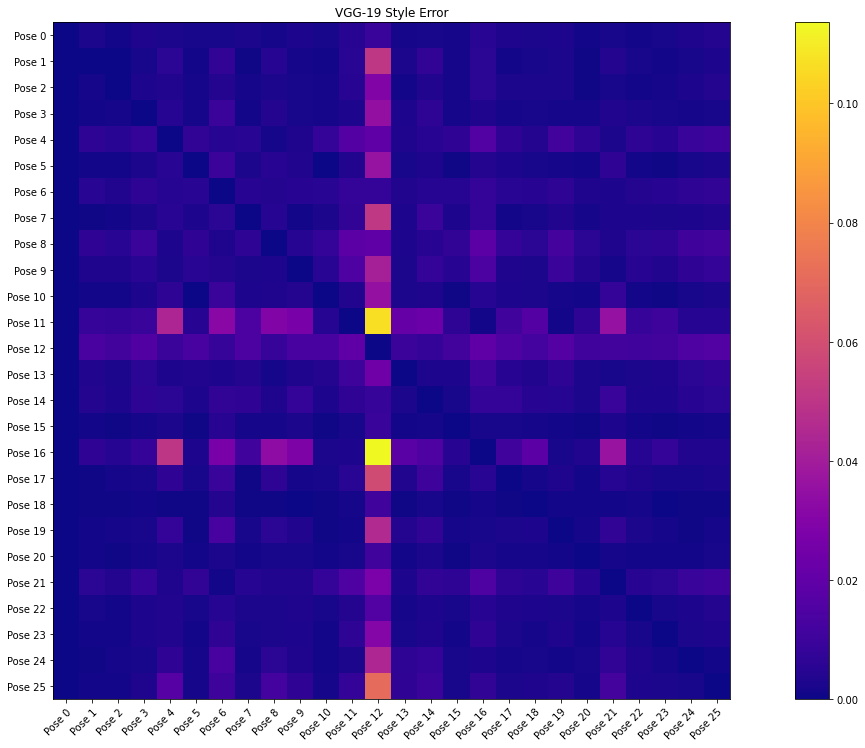

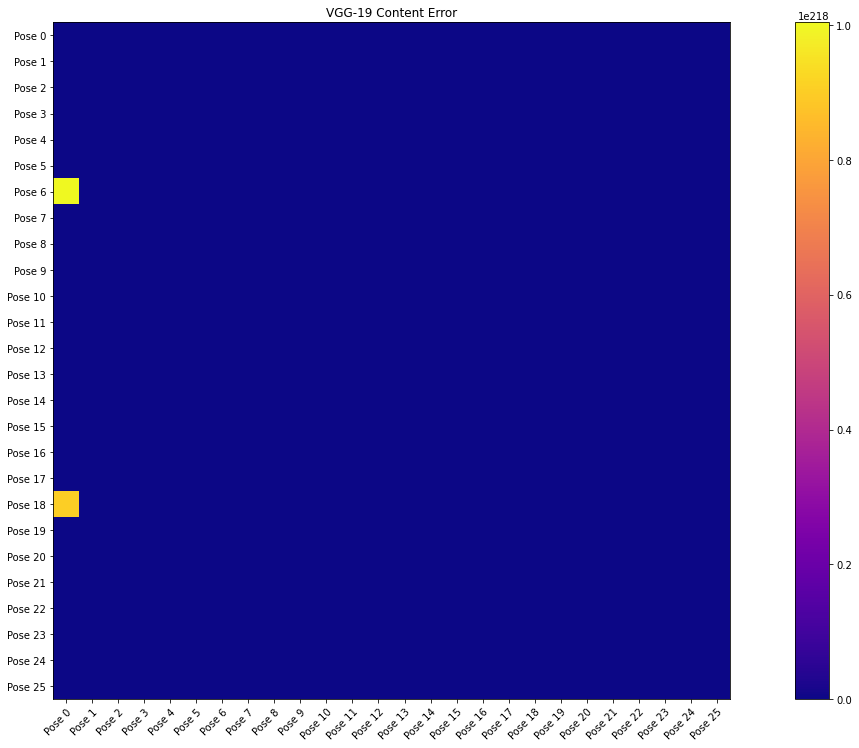

In [32]:
# for i in range(style_score_matrix.shape[0]):
#     for j in range(style_score_matrix.shape[0]):
#         style_score_matrix[j][i] = style_score_matrix[i][j]
#         content_score_matrix[j][i] = content_score_matrix[i][j]

create_heatmap(style_score_matrix, title="VGG-19 Style Error")
create_heatmap(content_score_matrix, title="VGG-19 Content Error")

# CLIP

In [37]:
from feature_losses.clip import CLIPWrapper, semantic_consistency_loss
import torch

clip = CLIPWrapper(device=DEVICE)
reference_img = dataset[0]['img'].to(DEVICE).unsqueeze(0)  # Add batch dimension
input_img = dataset[1]['img'].to(DEVICE).unsqueeze(0)  # Add batch dimension

In [4]:
with torch.no_grad():
    ref_embedding = clip.get_embedding(reference_img)
    input_embedding = clip.get_embedding(input_img)
print(ref_embedding.shape)

torch.Size([1, 512])


In [7]:
print(semantic_consistency_loss(ref_embedding, input_embedding).item())

0.9884337782859802


## CLIP Semantic Consistency between Poses

In [38]:
clip_embeddings = [
    clip.get_embedding(sample['img'].to(DEVICE).unsqueeze(0))
    for sample in dataset
]
print(f'Created {len(clip_embeddings)} embeddings')

Created 20 embeddings


In [39]:
for i in range(len(clip_embeddings) - 1):
    for j in range(i + 1, min(i + 3, len(dataset))):
        print(f'Pose {i}->{j}')
        print(f'Semantic loss: {semantic_consistency_loss(clip_embeddings[i], clip_embeddings[j]).item()}')
        print('\n\n')

Pose 0->1
Semantic loss: 0.979863703250885



Pose 0->2
Semantic loss: 0.9789341688156128



Pose 1->2
Semantic loss: 0.9835067987442017



Pose 1->3
Semantic loss: 0.9755411148071289



Pose 2->3
Semantic loss: 0.9795722961425781



Pose 2->4
Semantic loss: 0.9767123460769653



Pose 3->4
Semantic loss: 0.9867397546768188



Pose 3->5
Semantic loss: 0.9764719009399414



Pose 4->5
Semantic loss: 0.9812104105949402



Pose 4->6
Semantic loss: 0.9834597110748291



Pose 5->6
Semantic loss: 0.9750226140022278



Pose 5->7
Semantic loss: 0.9639784693717957



Pose 6->7
Semantic loss: 0.9816640615463257



Pose 6->8
Semantic loss: 0.9782612323760986



Pose 7->8
Semantic loss: 0.98813796043396



Pose 7->9
Semantic loss: 0.9748814105987549



Pose 8->9
Semantic loss: 0.9847720265388489



Pose 8->10
Semantic loss: 0.979943037033081



Pose 9->10
Semantic loss: 0.9849126935005188



Pose 9->11
Semantic loss: 0.9808655977249146



Pose 10->11
Semantic loss: 0.972942590713501



Pose 10->12
S

In [40]:
semantic_consistency_matrix = np.empty((len(clip_embeddings), len(clip_embeddings)))
for i, embedding_i in tqdm(enumerate(clip_embeddings)):
    for j, embedding_j in tqdm(enumerate(clip_embeddings)):
        loss = semantic_consistency_loss(embedding_i, embedding_j).item()
        semantic_consistency_matrix[i][j] = loss

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [42]:
np.save(os.path.join(output_dir, 'semantic_consistency_matrix.npy'), semantic_consistency_matrix)

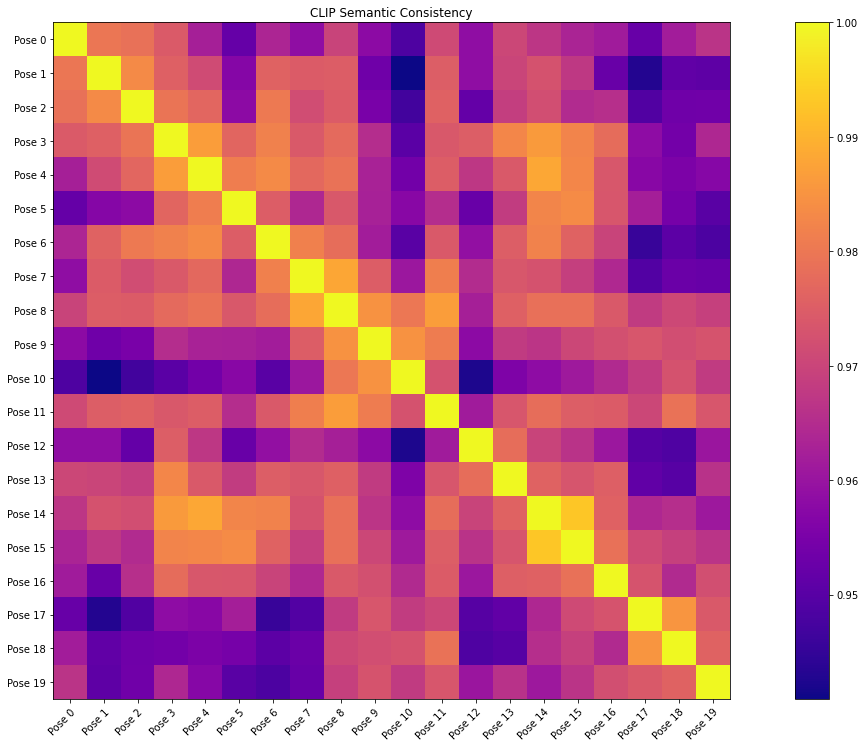

In [41]:
create_heatmap(semantic_consistency_matrix, title="CLIP Semantic Consistency")


In [80]:
output_dir_to_use = 'output/llff/trex/'

full_transformation_errors = np.load(os.path.join(output_dir_to_use, 'full_transformation_errors.npy'))
content_score_matrix = np.load(os.path.join(output_dir_to_use, 'content_score_matrix.npy'))
style_score_matrix = np.load(os.path.join(output_dir_to_use, 'style_score_matrix.npy'))
semantic_consistency_matrix = np.load(os.path.join(output_dir_to_use, 'semantic_consistency_matrix.npy'))

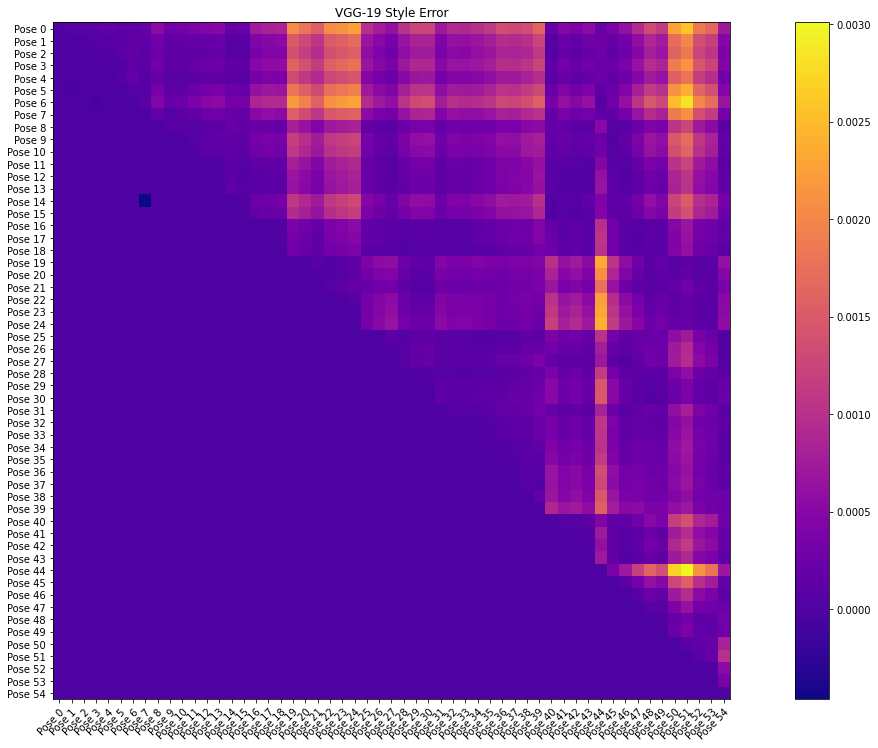

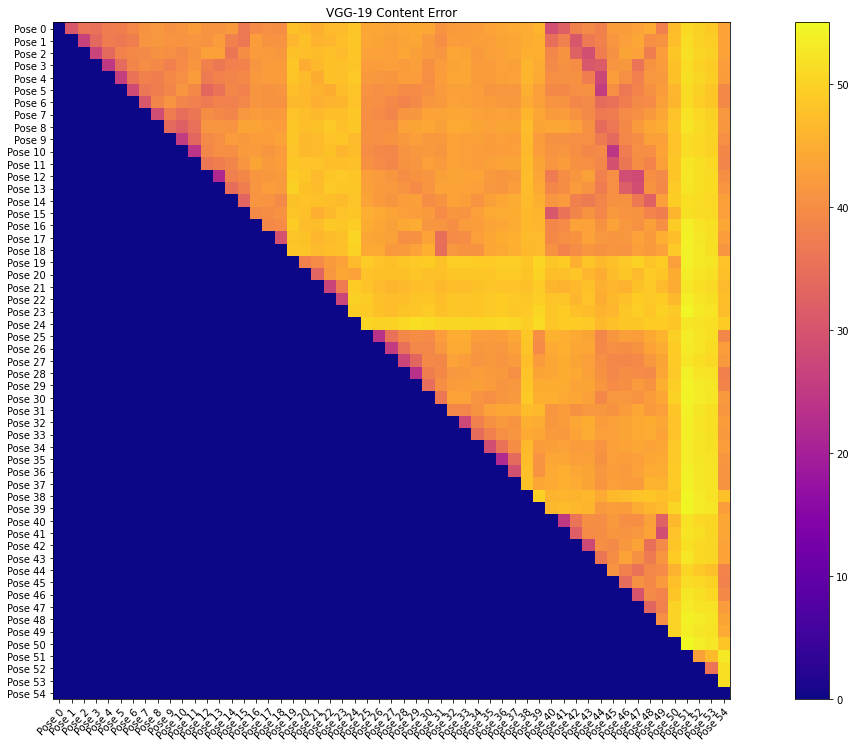

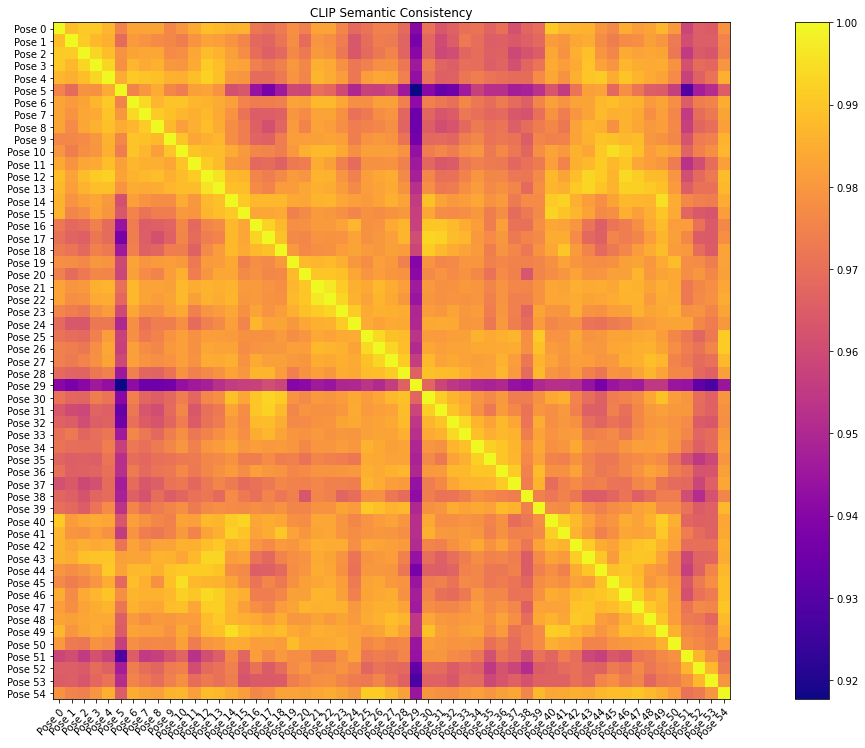

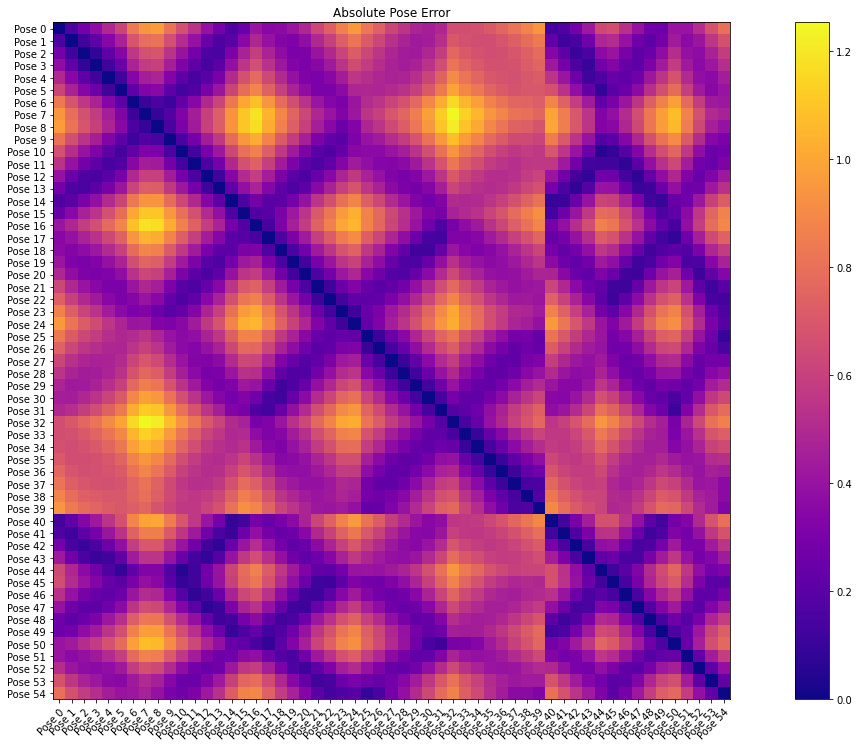

In [81]:
create_heatmap(style_score_matrix, title="VGG-19 Style Error")
create_heatmap(content_score_matrix, title="VGG-19 Content Error")
create_heatmap(semantic_consistency_matrix, title="CLIP Semantic Consistency")
create_heatmap(full_transformation_errors, title="Absolute Pose Error")

In [82]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


print(check_symmetric(full_transformation_errors))
print(check_symmetric(content_score_matrix))
print(check_symmetric(style_score_matrix))
print(check_symmetric(semantic_consistency_matrix))

True
False
False
True


In [83]:
triu_indices = np.triu_indices_from(full_transformation_errors, k=1)
full_trafo_errors_flat = full_transformation_errors[triu_indices]
content_score_flat = content_score_matrix[triu_indices]
style_score_flat = style_score_matrix[triu_indices]
semantic_flat = semantic_consistency_matrix[triu_indices]

In [48]:
def create_scatter(x, y, title, xlabel, ylabel, fig_size=(18.5, 10.5)):
    fig, ax = plt.subplots()
    fig.set_size_inches(*fig_size)
    im = ax.scatter(x, y, cmap='plasma')
    fig.colorbar(im)

    ax.set_xlabel(xlabel)

    plt.ylabel(ylabel)

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(full_trafo_errors_flat, content_score_flat)
fig.tight_layout()
plt.show()

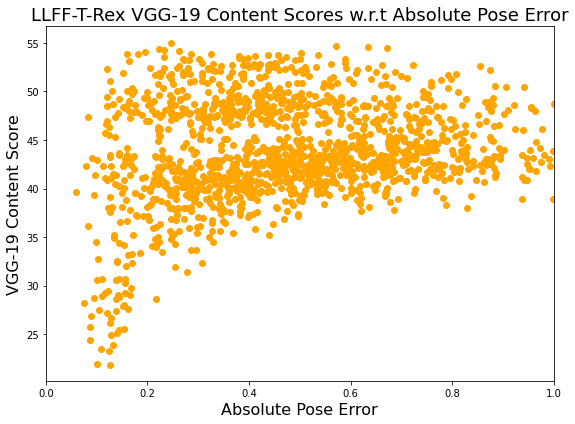

In [88]:
fig, ax = plt.subplots()
im = ax.scatter(full_trafo_errors_flat, content_score_flat,color='orange')

ax.set_xlabel('Absolute Pose Error',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylabel('VGG-19 Content Score',fontsize=16)
fig.set_size_inches(8,6)
ax.set_title('LLFF-T-Rex VGG-19 Content Scores w.r.t Absolute Pose Error',fontsize=18)
fig.tight_layout()
plt.savefig(os.path.join(output_dir_to_use, 'content_ape.png'),dpi=600)
plt.show()

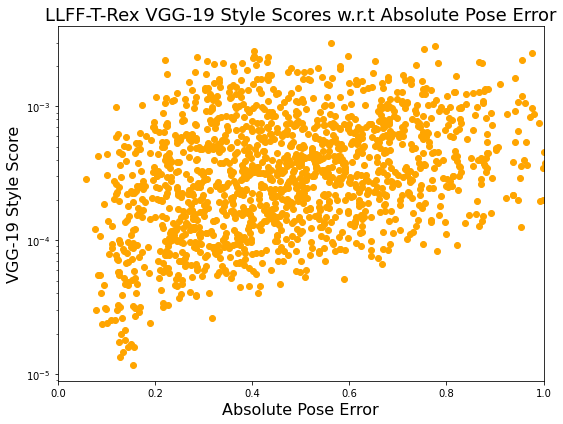

In [89]:
fig, ax = plt.subplots()
im = ax.scatter(full_trafo_errors_flat, style_score_flat,color='orange')

ax.set_xlabel('Absolute Pose Error',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylabel('VGG-19 Style Score',fontsize=16)
fig.set_size_inches(8,6)
ax.set_title('LLFF-T-Rex VGG-19 Style Scores w.r.t Absolute Pose Error',fontsize=18)
fig.tight_layout()
ax.set_yscale('log')
plt.savefig(os.path.join(output_dir_to_use, 'style_ape.png'),dpi=600)
plt.show()

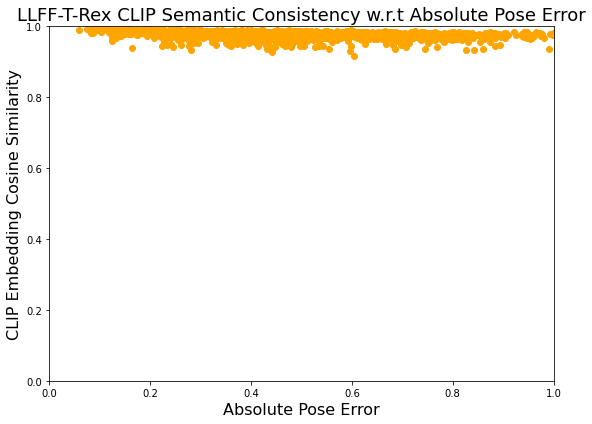

In [90]:
fig, ax = plt.subplots()
im = ax.scatter(full_trafo_errors_flat, semantic_flat,color='orange')

ax.set_xlabel('Absolute Pose Error',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel('CLIP Embedding Cosine Similarity',fontsize=16)
fig.set_size_inches(8,6)
ax.set_title('LLFF-T-Rex CLIP Semantic Consistency w.r.t Absolute Pose Error',fontsize=18)
fig.tight_layout()
# ax.set_yscale('log')
plt.savefig(os.path.join(output_dir_to_use, 'clip_ape.png'),dpi=600)
plt.show()